In [1]:
import cellcharter as cc
import scanpy as sc

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir = '/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_008um/'
adata = sc.read_h5ad(data_dir + 'combined.h5ad')

fdata = adata[:, ~adata.var_names.str.startswith('sg')].copy()
del adata

fdata_filtered = fdata[:, ~fdata.var_names.str.startswith('mt')].copy()

with open("../20240502-SPACseq/He2020Nature_mouseHK.txt", 'r') as f:
    for line in f:
        hk_genes = line.split('\t')
        break
fdata_filtered.var_names_make_unique()
fdata_filtered = fdata_filtered[:, [gene for gene in fdata_filtered.var_names if gene not in hk_genes]]
del fdata

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


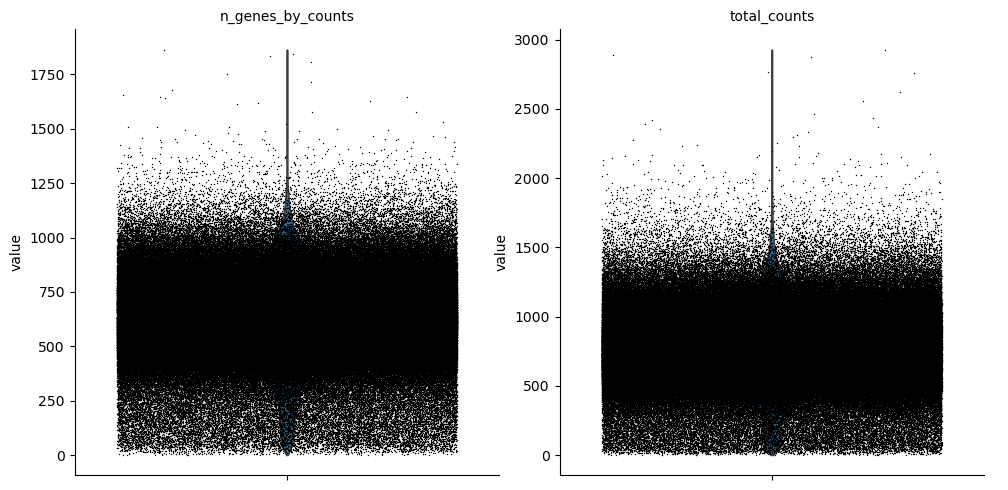

In [3]:
sc.pp.calculate_qc_metrics(fdata_filtered, inplace=True)
sc.pl.violin(fdata_filtered, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [4]:
sc.pp.filter_genes(fdata_filtered, min_cells=10)
sc.pp.filter_cells(fdata_filtered, min_counts=10)

fdata_filtered.layers['counts'] = fdata_filtered.X.copy()

sc.pp.normalize_total(fdata_filtered, target_sum=1e4)
sc.pp.log1p(fdata_filtered)

sc.pp.pca(fdata_filtered, n_comps=50)

In [5]:
fdata_filtered.write_h5ad(data_dir + 'combined_filtered_pca.h5ad')

In [6]:
fdata_filtered.X = fdata_filtered.layers['counts']

In [7]:
import scvi

scvi.settings.seed = 114514
scvi.model.SCVI.setup_anndata(fdata_filtered)
model=scvi.model.SCVI(fdata_filtered, n_hidden=32, n_latent=10, n_layers=5, gene_likelihood="poisson", latent_distribution="normal")

model.train(early_stopping=True, enable_progress_bar=True)
model.save(data_dir + "scvi.model", save_anndata=True, overwrite=True)

Global seed set to 0
Global seed set to 114514
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:1

Epoch 1/13:   0%|          | 0/13 [00:00<?, ?it/s]

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 13/13: 100%|██████████| 13/13 [21:17<00:00, 98.24s/it, loss=2.06e+03, v_num=1]


In [8]:
import numpy as np
import squidpy as sq
fdata_filtered.obsm["X_scVI"] = model.get_latent_representation(fdata_filtered).astype(np.float32)
sq.gr.spatial_neighbors(fdata_filtered, coord_type="generic", delaunay=False, spatial_key="spatial", radius=120)
cc.gr.remove_long_links(fdata_filtered)

In [9]:
cc.gr.remove_long_links(fdata_filtered)
cc.gr.aggregate_neighbors(fdata_filtered, n_layers=3, use_rep="X_scVI", out_key="X_cellcharter", sample_key="marker")

100%|██████████| 4/4 [01:13<00:00, 18.45s/it]


Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:01<00:16,  1.07s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:05<00:46,  3.32s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:08,  1.80it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:04<00:32,  2.34s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:07,  1.97it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:03<00:31,  2.26s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:03<00:28,  2.06s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:09,  1.66it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:04<00:31,  2.27s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:08,  1.82it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:04<00:36,  2.64s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:10,  1.42it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:05<00:46,  3.30s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:11,  1.29it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:05<00:46,  3.31s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:13,  1.10it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:08<01:07,  4.81s/it]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Convergence with a change in stability of 0.007504679872175451 reached after 9 iterations


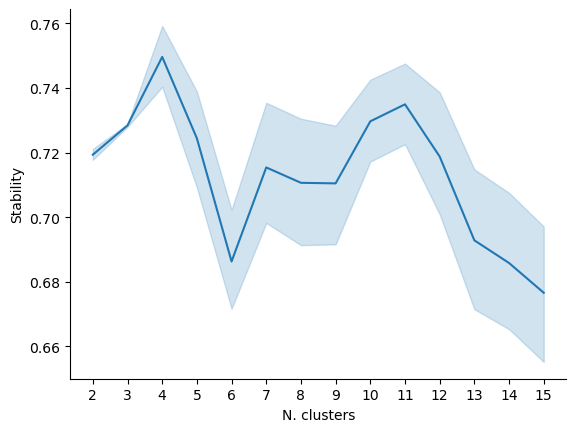

In [10]:
autok = cc.tl.ClusterAutoK(
    n_clusters = (2,15),
    max_runs = 10,
    model_params = dict(
        random_state = 114514
    )
)
autok.fit(fdata_filtered, use_rep="X_cellcharter")
cc.pl.autok_stability(autok)

In [24]:
# fdata_filtered.obs["cluster"] = autok.predict(fdata_filtered, use_rep="X_cellcharter")
givenk = cc.tl.Cluster(
    n_clusters=7,
)
givenk.fit(fdata_filtered, use_rep="X_cellcharter")
fdata_filtered.obs["cluster"] = givenk.predict(fdata_filtered, use_rep="X_cellcharter")

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(


In [17]:
autok.save(data_dir + "autok_model.pkl")

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/tl/_autok.py:227: UserWarning: Failed to serialize parameters of `ClusterAutoK` to JSON. Falling back to `pickle`.
  self._save_parameters(path)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightkit/estimator/base.py:170: UserWarning: Failed to serialize parameters of `GaussianMixture` to JSON. Falling back to `pickle`.
  warnings.warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightkit/estimator/base.py:202: UserWarning: Failed to serialize fitted attributes of `GaussianMixture` to JSON. Falling back to `pickle`.
  warnings.warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/tl/_autok.py:228: UserWarning: Failed to serialize fitted attributes of `ClusterAutoK` to JSON. Falling back to `pickle`.
  self._save_attributes(path, best_k=best_k)


In [25]:
givenk.save(data_dir + "givenk_model.pkl")

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightkit/estimator/base.py:170: UserWarning: Failed to serialize parameters of `Cluster` to JSON. Falling back to `pickle`.
  warnings.warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightkit/estimator/base.py:202: UserWarning: Failed to serialize fitted attributes of `Cluster` to JSON. Falling back to `pickle`.
  warnings.warn(


/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Text(0.5, 1.0, '')

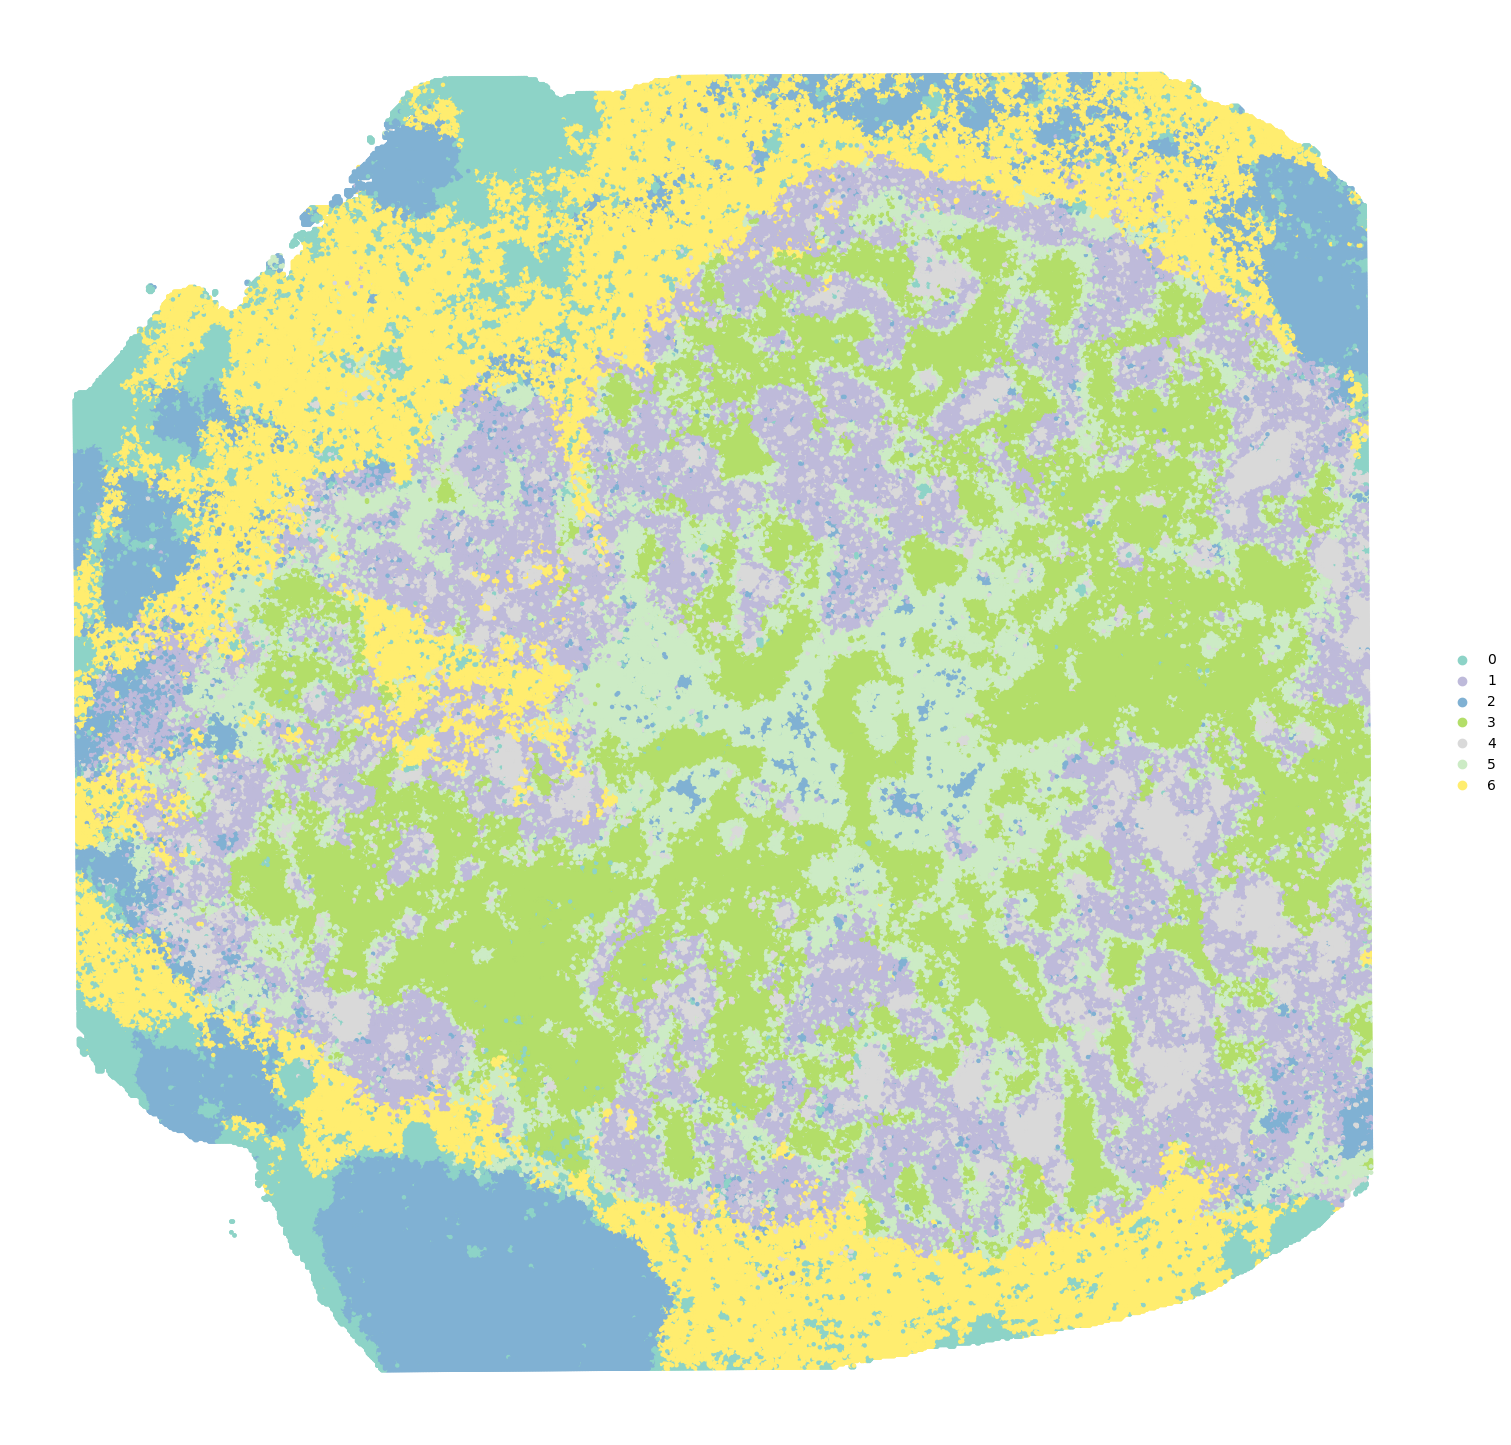

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sq.pl.spatial_scatter(
    fdata_filtered, 
    color=['cluster'], 
    size=20, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(15,15),
    shape=None,
    return_ax=True
)
sns.despine(left=True, bottom=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

In [27]:
fdata_filtered.write_h5ad(data_dir + 'combined_cellcharter.h5ad')